In [3]:
import sys
import os

sys.path.append('../../')
from global_variables import SUBDIR, WORKSPACE

In [4]:
import re
import numpy as np
import pandas as pd

## Parsers

def get_seq_df_input_symbols(input_df, seq_df, mane=False):
    """
    Update gene names (HUGO Symbols) of O3D built sequence with names in input file.
    Do it only for entries in the sequence df with available transcript information
    and use transcript ID to get gene name.
    """

    # Split sequence df by entries with available transcript info (Reference_info 0 and 1) and not available ones (-1)
    seq_df_tr_missing = seq_df[seq_df["Reference_info"] == -1].reset_index(drop=True)
    seq_df_tr_available = seq_df[seq_df["Reference_info"] != -1].reset_index(drop=True)

    # Use names from input
    df_mapping = input_df[["Hugo_Symbol", "Feature"]].rename(columns={"Hugo_Symbol" : "Gene", "Feature" : "Ens_Transcr_ID"})
    seq_df_tr_available = seq_df_tr_available.drop(columns=["Gene"]).drop_duplicates().merge(df_mapping, how="left", on="Ens_Transcr_ID")

    # If the same gene is associated to multiple structures, keep the first one obtained from Uniprot (descending, Reference_info 1) or keep the MANE (ascending, Reference_info 0)
    # TO DO: Use the one reviewed (UniProtKB reviewed (Swiss-Prot)), if multiple Uniprot ones are present. The info must be added during the build step
    order_ascending = [True, mane]
    seq_df_tr_available = seq_df_tr_available.sort_values(by=["Gene", "Reference_info"], ascending=order_ascending).drop_duplicates(subset="Gene")

    # If the same genes is associated to multiple structures, keep the one not obtained by Backtranseq (Reference_info 1 or 0)
    seq_df = pd.concat([seq_df_tr_missing, seq_df_tr_available]).sort_values(by=["Gene", "Reference_info"], ascending=[True, False])

    return seq_df.drop_duplicates(subset="Gene").reset_index(drop=True)


def get_hgvsp_mut(df_row):
    """
    Parse mutation entries to get HGVSp_Short format.
    """
    
    amino_acids = df_row["Amino_acids"]
    
    if pd.isna(amino_acids):
        return np.nan
    
    amino_acids = amino_acids.split("/")
    if len(amino_acids) > 1:
        return f"p.{amino_acids[0]}{df_row['Protein_position']}{amino_acids[1]}"
    
    return np.nan
                
                
def filter_transcripts(df, seq_df):
    """
    Filter VEP output by Oncodrive3D transcripts. For genes with NA 
    transcripts in the sequence dataframe, keep canonical ones.
    """
    
    if "CANONICAL" in df.columns and "Feature" in df.columns:
        
        # Genes without available transcript info in O3D built datasets
        df_tr_missing = df[df["Hugo_Symbol"].isin(seq_df.loc[seq_df["Reference_info"] == -1, "Gene"])]
        df_tr_missing = df_tr_missing[df_tr_missing["CANONICAL"] == "YES"]
        
        # Genes with transcript info
        df_tr_available = df[df["Feature"].isin(seq_df.loc[seq_df["Reference_info"] != -1, "Ens_Transcr_ID"])]
        
        return pd.concat((df_tr_available, df_tr_missing))
    
    else:
        print("Failed to filter input by O3D transcripts. Please provide as input the output of VEP with canonical and transcripts information: Exiting..")
        sys.exit(1)


def parse_vep_output(df,
                     seq_df=None, 
                     use_o3d_transcripts=False, 
                     use_input_symbols=False, 
                     mane=False):
    """
    Parse the dataframe in case it is the direct output of VEP without any 
    processing. Rename the columns to match the fields name of a MAF file, 
    and select the canonical transcripts if multiple ones are present.
    """

    df.rename(columns={"SYMBOL": "Hugo_Symbol",
                       "Consequence": "Variant_Classification"}, inplace=True)
            
    # Adapt HUGO_Symbol in seq_df to input file
    if seq_df is not None and use_input_symbols:
        print("Adapting Oncodrive3D HUGO Symbols of built datasets to input file..")
        seq_df = get_seq_df_input_symbols(df, seq_df, mane)
    
    # Transcripts filtering
    if use_o3d_transcripts and seq_df is not None:
        print("Filtering input by Oncodrive3D built transcripts..")
        df = filter_transcripts(df, seq_df)
    elif "CANONICAL" in df.columns:
        df = df[df["CANONICAL"] == "YES"]
            
    # Get HGVSp
    if "HGVSp_Short" not in df.columns and "Amino_acids" in df.columns and "Protein_position" in df.columns:
        df["HGVSp_Short"] = df.apply(get_hgvsp_mut, axis=1)
        
    return df, seq_df


def parse_mutations(maf):
    """
    Parse HGVSp_Short in maf.
    """
    
    # Ensure the required 'HGVSp_Short' column is present and not empty
    if 'HGVSp_Short' not in maf.columns or maf['HGVSp_Short'].isnull().all():
        print("Missing or empty 'HGVSp_Short' column in input MAF data.")
        sys.exit(1)

    # Parse the position, wild type, and mutation type from 'HGVSp_Short'
    maf.dropna(subset="HGVSp_Short", inplace=True)
    maf['Pos'] = maf['HGVSp_Short'].apply(lambda x: re.sub(r"\D", "", x)).astype(np.int32)
    maf['WT'] = maf['HGVSp_Short'].apply(lambda x: re.findall(r"\D", x)[2])
    maf['Mut'] = maf['HGVSp_Short'].apply(lambda x: re.findall(r"\D", x)[3])

    # Parse cols
    columns_to_keep = ['Hugo_Symbol', 'Pos', 'WT', 'Mut', 'Tumor_Sample_Barcode', 'Feature', 'Transcript_ID']
    columns_to_keep = [col for col in columns_to_keep if col in maf.columns]
    maf = maf[columns_to_keep]
    maf = maf.rename(columns={'Hugo_Symbol' : 'Gene', 'Feature': 'Transcript_ID'})

    return maf.sort_values(by=['Gene', 'Pos']).reset_index(drop=True)


def add_transcript_info(maf, seq_df):
    """
    Add transcript status information.
    """
    
    if 'Transcript_ID' not in maf.columns:
        maf['Transcript_ID'] = np.nan
    maf = maf.merge(seq_df[[col for col in ['Gene', 'Ens_Transcr_ID', 'Refseq_prot'] if col in seq_df.columns]].drop_duplicates(), 
                    on='Gene', how='left').rename(columns={"Ens_Transcr_ID" : "O3D_transcript_ID"})

    # Vectorized conditions for setting Transcript_status
    conditions = [
        maf['Transcript_ID'].isna(),
        maf['O3D_transcript_ID'].isna(),
        maf['Transcript_ID'] != maf['O3D_transcript_ID'],
        maf['Transcript_ID'] == maf['O3D_transcript_ID']
    ]
    choices = ['Input_missing', 'O3D_missing', 'Mismatch', 'Match']
    maf['Transcript_status'] = np.select(conditions, choices, default=np.nan)

    # Log transcript report
    transcript_report = maf['Transcript_status'].value_counts().reset_index(name='Count')
    transcript_report = ", ".join([f"{status} = {count}" for status, count in transcript_report.to_numpy()])
    print(f"Transcript status of {len(maf)} mutations: {transcript_report}")

    return maf


def read_input(input_path):
    """
    Read input file optimizing memory usage.
    """

    cols_to_read = ["Variant_Classification",
                    "Tumor_Sample_Barcode",
                    "Feature", 
                    "Transcript_ID",
                    "Consequence", 
                    "SYMBOL", 
                    "Hugo_Symbol",
                    "CANONICAL", 
                    "HGVSp_Short",
                    "Amino_acids", 
                    "Protein_position"]
    
    header = pd.read_table(input_path, nrows=0)
    cols_to_read = [col for col in cols_to_read if col in header.columns]
    dtype_mapping = {col : "object" for col in cols_to_read}
    dtype = {key: dtype_mapping[key] for key in cols_to_read if key in dtype_mapping}
    
    return pd.read_table(input_path, usecols=cols_to_read, dtype=dtype)


def parse_maf_input(input_path, seq_df=None, use_o3d_transcripts=False, use_input_symbols=False, mane=False):
    """
    Parsing and process MAF input data.
    """

    # Load, parse from VEP and update seq_df if needed
    print("Reading input mutations file..")
    maf = read_input(input_path)
    print(f"Processing [{len(maf)}] total mutations..")
    maf, seq_df = parse_vep_output(maf, seq_df, use_o3d_transcripts, use_input_symbols, mane)

    # Extract and parse missense mutations
    maf = maf[maf['Variant_Classification'].str.contains('Missense_Mutation|missense_variant')]
    if "Protein_position" in maf.columns:
        maf = maf[~maf['Protein_position'].astype(str).str.contains('-')] # Filter DBS
    print(f"Processing [{len(maf)}] missense mutations..")
    maf = parse_mutations(maf)                       
    
    # Add transcript status from seq_df
    if seq_df is not None:
        maf = add_transcript_info(maf, seq_df)
    
    return maf.reset_index(drop=True), seq_df


In [5]:
o3d_datasets_dir = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506"
seq_df = pd.read_csv(os.path.join(o3d_datasets_dir, "seq_for_mut_prob.tsv"), sep="\t")

In [6]:
cohort = "TCGA_WXS_LUAD"
o3d_datasets_dir = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506"
seq_df = pd.read_csv(os.path.join(o3d_datasets_dir, "seq_for_mut_prob.tsv"), sep="\t")
input_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/vep/{cohort}.vep.tsv.gz"
data, seq_df = parse_maf_input(input_path, 
                                seq_df, 
                                use_o3d_transcripts=True,
                                use_input_symbols=True, 
                                mane=True)


Reading input mutations file..
Processing [1358452] total mutations..
Adapting Oncodrive3D HUGO Symbols of built datasets to input file..
Filtering input by Oncodrive3D built transcripts..
Processing [98457] missense mutations..
Transcript status of 98457 mutations: Match = 94233, O3D_missing = 4224


In [7]:
data = data[data["Gene"] == "TP53"].reset_index(drop=True)
data

,Gene,Pos,WT,Mut,Transcript_ID,O3D_transcript_ID,Transcript_status
0,TP53,57,D,N,ENST00000269305,ENST00000269305,Match
1,TP53,77,P,L,ENST00000269305,ENST00000269305,Match
2,TP53,105,G,D,ENST00000269305,ENST00000269305,Match
3,TP53,105,G,D,ENST00000269305,ENST00000269305,Match
4,TP53,105,G,C,ENST00000269305,ENST00000269305,Match
...,...,...,...,...,...,...,...
166,TP53,337,R,L,ENST00000269305,ENST00000269305,Match
167,TP53,337,R,P,ENST00000269305,ENST00000269305,Match
168,TP53,337,R,C,ENST00000269305,ENST00000269305,Match
169,TP53,337,R,C,ENST00000269305,ENST00000269305,Match


In [8]:
data_top1 = data.drop_duplicates(subset=["Gene", "Pos"], keep="first")
data_top1

,Gene,Pos,WT,Mut,Transcript_ID,O3D_transcript_ID,Transcript_status
0,TP53,57,D,N,ENST00000269305,ENST00000269305,Match
1,TP53,77,P,L,ENST00000269305,ENST00000269305,Match
2,TP53,105,G,D,ENST00000269305,ENST00000269305,Match
5,TP53,110,R,L,ENST00000269305,ENST00000269305,Match
8,TP53,120,K,E,ENST00000269305,ENST00000269305,Match
...,...,...,...,...,...,...,...
157,TP53,286,E,G,ENST00000269305,ENST00000269305,Match
162,TP53,331,Q,H,ENST00000269305,ENST00000269305,Match
163,TP53,334,G,V,ENST00000269305,ENST00000269305,Match
166,TP53,337,R,L,ENST00000269305,ENST00000269305,Match


In [9]:
data_top3 = data.groupby(["Gene", "Pos"], as_index=False).head(1)
data_top3

,Gene,Pos,WT,Mut,Transcript_ID,O3D_transcript_ID,Transcript_status
0,TP53,57,D,N,ENST00000269305,ENST00000269305,Match
1,TP53,77,P,L,ENST00000269305,ENST00000269305,Match
2,TP53,105,G,D,ENST00000269305,ENST00000269305,Match
5,TP53,110,R,L,ENST00000269305,ENST00000269305,Match
8,TP53,120,K,E,ENST00000269305,ENST00000269305,Match
...,...,...,...,...,...,...,...
157,TP53,286,E,G,ENST00000269305,ENST00000269305,Match
162,TP53,331,Q,H,ENST00000269305,ENST00000269305,Match
163,TP53,334,G,V,ENST00000269305,ENST00000269305,Match
166,TP53,337,R,L,ENST00000269305,ENST00000269305,Match


In [10]:
data_top5 = data.groupby(["Gene", "Pos"], as_index=False).head(5)
data_top5

,Gene,Pos,WT,Mut,Transcript_ID,O3D_transcript_ID,Transcript_status
0,TP53,57,D,N,ENST00000269305,ENST00000269305,Match
1,TP53,77,P,L,ENST00000269305,ENST00000269305,Match
2,TP53,105,G,D,ENST00000269305,ENST00000269305,Match
3,TP53,105,G,D,ENST00000269305,ENST00000269305,Match
4,TP53,105,G,C,ENST00000269305,ENST00000269305,Match
...,...,...,...,...,...,...,...
166,TP53,337,R,L,ENST00000269305,ENST00000269305,Match
167,TP53,337,R,P,ENST00000269305,ENST00000269305,Match
168,TP53,337,R,C,ENST00000269305,ENST00000269305,Match
169,TP53,337,R,C,ENST00000269305,ENST00000269305,Match


### Mut profile

In [11]:
from itertools import product
import json


def get_unif_gene_miss_prob(size):
    """
    Get a uniformly distributed gene missense mutation 
    probability vector.
    """
    
    vector = np.ones(size)
    vector[0] = 0
    
    return vector / sum(vector)


def mut_rate_vec_to_dict(mut_rate):
    """
    Convert the vector of mut mut_rate of 96 channels to a dictionary of 192 
    items: the keys are mutations in trinucleotide context (e.g., "ACA>A") 
    and values are the corresponding mut rate (frequency of mut normalized 
    for the nucleotide content).
    """
    
    cb  = dict(zip('ACGT', 'TGCA'))
    mut_rate_dict = {}
    i = 0
    for ref in ['C', 'T']:
        for alt in cb.keys():
            if ref == alt:
                continue
            else:
                for p in product(cb.keys(), repeat=2):
                    mut = f"{p[0]}{ref}{p[1]}>{alt}"
                    cmut = f"{cb[p[1]]}{cb[ref]}{cb[p[0]]}>{cb[alt]}"
                    mut_rate_dict[mut] = mut_rate[i]
                    mut_rate_dict[cmut] = mut_rate[i]
                    i +=1
                    
    return mut_rate_dict


def get_codons(dna_seq):
    """
    Get the list of codons from a DNA sequence.
    """
    
    return [dna_seq[i:i+3] for i in [n*3 for n in range(int(len(dna_seq) / 3))]]


def translate_dna_to_prot(dna_seq, gencode):
    """
    Translate a DNA sequence into amino acid sequence.
    """
    
    return "".join([gencode[codon] for codon in get_codons(dna_seq)])


def codons_trinucleotide_context(lst_contexts):
    
    return list(zip(lst_contexts[::3], lst_contexts[1::3], lst_contexts[2::3]))


# TODO: doc function

def get_miss_mut_prob(dna_seq, 
                      dna_tricontext, 
                      mut_rate_dict, 
                      mutability=False, 
                      get_probability=True, 
                      mut_start_codon=False):
    """
    Generate a list including the probabilities that the 
    codons can mutate resulting into a missense mutations.
    
    Arguments
    ---------
    dna_seq: str
        Sequence of DNA
    mut_rate_dict: dict
        Mutation rate probability as values and the 96 possible
        trinucleotide contexts as keys
    gencode: dict
        Nucleotide as values and codons as keys
        
    Returns
    -------
    missense_prob_vec: list
        List of probabilities (one for each codon or prot res) 
        of a missense mutation  
    """

    # Initialize
    gencode = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'}

    # Get all codons of the seq
    #logger.debug("Getting codons of seq..")
    codons = get_codons(dna_seq)
    missense_prob_vec = []
    
    # Get the trinucleotide context as list of tuples of 3 elements corresponding to each codon   
    #logger.debug("Getting tri context seq..")                               
    tricontext = codons_trinucleotide_context(dna_tricontext.split(","))
    
    # Iterate through codons and get prob of missense based on context
    for c in range(len(codons)):
        missense_prob = 0
        codon = codons[c]
        aa = gencode[codon]         
        trinucl0, trinucl1, trinucl2  = tricontext[c]

        # Iterate through the possible contexts of a missense mut
        for i, trinucl in enumerate([trinucl0, trinucl1, trinucl2]):
            ref = trinucl[1]
            aa = gencode[codon]

            # Iterate through the possible alt 
            for alt in "ACGT":
                if alt != ref:         
                    alt_codon = [n for n in codon]
                    alt_codon[i] = alt
                    alt_codon = "".join(alt_codon)
                    alt_aa = gencode[alt_codon]  
                    # If there is a missense mut, get prob from context and sum it
                    if alt_aa != aa and alt_aa != "_":
                        if not mutability:
                            mut = f"{trinucl}>{alt}"    # query using only the trinucleotide change
                            mut_prob = mut_rate_dict[mut] if mut in mut_rate_dict else 0                                                                 
                            missense_prob += mut_prob

                        else:
                            cdna_pos = (c * 3) + i  # compute the cDNA position of the residue
                            if cdna_pos in mut_rate_dict:
                                missense_prob += mut_rate_dict[cdna_pos].get(alt, 0)
                            else:
                                missense_prob += 0

        missense_prob_vec.append(missense_prob)

    # Assign 0 prob to the first residue
    if mut_start_codon == False:
        missense_prob_vec[0] = 0
        
    # Convert into probabilities
    if get_probability:
        missense_prob_vec = np.array(missense_prob_vec) / sum(missense_prob_vec)
    
    return list(missense_prob_vec)


def get_miss_mut_prob_dict(mut_rate_dict, seq_df, mutability=False, mutability_config=None):
    """
    Given a dictionary of mut rate in 96 contexts (mut profile) and a 
    dataframe including Uniprot ID, HUGO symbol and DNA sequences, 
    get a dictionary with UniprotID-Fragment as keys and corresponding 
    vectors of missense mutation probabilities as values.
    """

    miss_prob_dict = {}

    if mutability:
        # TODO if the execution time of this step is too long we could
        # parallelize all these loops so that each gene is done in parallel

        # Process any Protein/fragment in the sequence df
        for _, row in seq_df.iterrows():
            # Mutabilities
            mutability_dict = Mutabilities(row.Uniprot_ID, row.Chr, row.Exons_coord, len(row.Seq_dna), row.Reverse_strand, mutability_config).mutabilities_by_pos
            miss_prob_dict[f"{row.Uniprot_ID}-F{row.F}"] = get_miss_mut_prob(row.Seq_dna, row.Tri_context, mutability_dict, mutability=True)

    else:
        # Process any Protein/fragment in the sequence df
        for _, row in seq_df.iterrows():
            miss_prob_dict[f"{row.Uniprot_ID}-F{row.F}"] = get_miss_mut_prob(row.Seq_dna, row.Tri_context, mut_rate_dict)
    
    return miss_prob_dict


def get_cmap(cmap_path, uniprot_id, af_f, cmap_prob_thr=0.5):
    
    cmap_complete_path = f"{cmap_path}/{uniprot_id}-F{af_f}.npy"
    cmap = np.load(cmap_complete_path) 
    cmap = cmap > cmap_prob_thr
    cmap = cmap.astype(int)
    
    return cmap


def get_vol_miss_prob(gene, cmap_path, miss_prob_dict, seq_df):
    
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    uniprot_id = seq_df_gene['Uniprot_ID'].values[0]
    af_f = seq_df_gene['F'].values[0]
    
    cmap = get_cmap(cmap_path, uniprot_id, af_f)
    gene_miss_prob = np.array(miss_prob_dict[f"{uniprot_id}-F{af_f}"])
    vol_missense_mut_prob = np.dot(cmap, gene_miss_prob)
    
    return vol_missense_mut_prob
    

cmap_path = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506/prob_cmaps"
mut_profile_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/mut_profile/{cohort}.sig.json"
mut_profile = json.load(open(mut_profile_path, encoding="utf-8"))
miss_prob_dict = get_miss_mut_prob_dict(mut_rate_dict=mut_profile, seq_df=seq_df)

vol_miss_prob = get_vol_miss_prob("TP53", cmap_path, miss_prob_dict, seq_df)

### Simulations

In [12]:
def simulate_unique_mutations(n_mutations, p, size, seed=None):
    """
    Simulate mutations such that no residue is mutated more than once per sample.
    
    Parameters:
    - n_mutations: number of mutations per sample
    - p: probability distribution over residues (must sum to 1)
    - size: number of samples to generate
    - seed: optional random seed
    
    Returns:
    - samples: array of shape (size, n_mutations) with selected residue indices
    """
    rng = np.random.default_rng(seed)
    n_residues = len(p)
    
    if n_mutations > n_residues:
        raise ValueError("n_mutations cannot exceed the number of residues (len(p)) when sampling without replacement.")
    
    samples = np.empty((size, n_mutations), dtype=int)
    for i in range(size):
        samples[i] = rng.choice(n_residues, size=n_mutations, replace=False, p=p)
    
    return samples

In [13]:
def simulate_mutations(n_mutations, p, size, seed=None):
    """
    Simulate the mutations given the mutation rate of a cohort.
    """

    rng = np.random.default_rng(seed=seed)
    samples = rng.multinomial(n_mutations, p, size=size)
    
    return samples

# Hotspots analysis

In [14]:
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Mut_in_vol", "Score", "Score_obs_sim", "Rank", "pval", 'C', 'C_ext']
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df).reset_index(drop=True)

    return df


def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene", 'C_gene', 'C_pos']].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)

    return df.reset_index(drop=True)


def load_significant_o3d_data(path, cohort_df, cgc_df):
    
    df = get_all_o3d_gene_result(cohort_df, path)
    df_res = get_all_o3d_res_result(cohort_df, path)
    df = df[df["C_gene"] == 1].reset_index(drop=True)
    df_res = df_res[(df_res["C"] == 1) & (df_res["C_ext"] == 0)].reset_index(drop=True)
    
    df["CGC"] = df.Gene.isin(cgc_df.Gene.unique()).astype(int)
    df_res["CGC"] = df_res.Gene.isin(cgc_df.Gene.unique()).astype(int)
    df["Tumour suppressor"] = df.Gene.isin(cgc_df[cgc_df["Gene_action"] == "Tumour suppressor"].Gene.unique()).astype(int)
    df_res["Tumour suppressor"] = df_res.Gene.isin(cgc_df[cgc_df["Gene_action"] == "Tumour suppressor"].Gene.unique()).astype(int)
    df["Oncogene"] = df.Gene.isin(cgc_df[cgc_df["Gene_action"] == "Oncogene"].Gene.unique()).astype(int)
    df_res["Oncogene"] = df_res.Gene.isin(cgc_df[cgc_df["Gene_action"] == "Oncogene"].Gene.unique()).astype(int)
    
    print(f"Genes = {len(df.Gene.unique())}\nGene-Cohort = {len(df)}\nClusters = {len(df_res)}\n")
    print(f"CGC Genes = {len(df[df['CGC'] == 1].Gene.unique())}\nCGC Gene-Cohort = {len(df[df['CGC'] == 1])}\nCGC Clusters = {len(df_res[df_res['CGC'] == 1])}\n")
    print(f"TSG Genes = {len(df[df['Tumour suppressor'] == 1].Gene.unique())}\nTSG Gene-Cohort = {len(df[df['Tumour suppressor'] == 1])}\nTSG Clusters = {len(df_res[df_res['Tumour suppressor'] == 1])}\n")
    print(f"GoF Genes = {len(df[df['Oncogene'] == 1].Gene.unique())}\nGoF Gene-Cohort = {len(df[df['Oncogene'] == 1])}\nGoF Clusters = {len(df_res[df_res['Oncogene'] == 1])}\n")
    
    return df, df_res


def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action

In [16]:
SUBDIR = "review"
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
output_path = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

all_path = f"{output_path}/run_control_2025-03-21_11-24-24"
k5_path = f"{output_path}/run_hotspots_removal_k5_2025-04-04_11-14-34/"
k3_path = f"{output_path}/run_hotspots_removal_k3_2025-04-05_02-24-53/"
k1_path = f"{output_path}/run_hotspots_removal_k1_2025-04-06_00-34-32/"

In [17]:
cgc_df = pd.read_csv(f"{datasets}input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df.loc[cgc_df["Gene"] == "TP53", "Gene_action"] = "Tumour suppressor"
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [18]:
print("> Original:")
df_all, df_all_res = load_significant_o3d_data(all_path, cohort_df, cgc_df)

print("\n> K5:")
df_k5, df_k5_res = load_significant_o3d_data(k5_path, cohort_df, cgc_df)
df_k5["K5"] = 1
df_k5_res["K5"] = 1

print("\n> K3:")
df_k3, df_k3_res = load_significant_o3d_data(k3_path, cohort_df, cgc_df)
df_k3["K3"] = 1
df_k3_res["K3"] = 1

print("\n> K1:")
df_k1, df_k1_res = load_significant_o3d_data(k1_path, cohort_df, cgc_df)
df_k1["K1"] = 1
df_k1_res["K1"] = 1

> Original:
Genes = 273
Gene-Cohort = 619
Clusters = 5872

CGC Genes = 106
CGC Gene-Cohort = 429
CGC Clusters = 3662

TSG Genes = 25
TSG Gene-Cohort = 138
TSG Clusters = 2208

GoF Genes = 54
GoF Gene-Cohort = 245
GoF Clusters = 1136


> K5:
Genes = 218
Gene-Cohort = 506
Clusters = 5981

CGC Genes = 89
CGC Gene-Cohort = 362
CGC Clusters = 3814

TSG Genes = 21
TSG Gene-Cohort = 129
TSG Clusters = 2295

GoF Genes = 44
GoF Gene-Cohort = 191
GoF Clusters = 1202


> K3:
Genes = 140
Gene-Cohort = 351
Clusters = 5446

CGC Genes = 74
CGC Gene-Cohort = 276
CGC Clusters = 3522

TSG Genes = 19
TSG Gene-Cohort = 119
TSG Clusters = 2252

GoF Genes = 34
GoF Gene-Cohort = 121
GoF Clusters = 977


> K1:
Genes = 28
Gene-Cohort = 73
Clusters = 2663

CGC Genes = 19
CGC Gene-Cohort = 63
CGC Clusters = 2007

TSG Genes = 9
TSG Gene-Cohort = 48
TSG Clusters = 1649

GoF Genes = 4
GoF Gene-Cohort = 8
GoF Clusters = 212



In [19]:
df = df_all[["Gene", "Cohort", "C_gene", "CGC", "Tumour suppressor", "Oncogene"]].copy()
df["All"] = 1
df = df.merge(df_k5[["Gene", "Cohort", "K5"]], on=["Gene", "Cohort"], how="left")
df = df.merge(df_k3[["Gene", "Cohort", "K3"]], on=["Gene", "Cohort"], how="left")
df = df.merge(df_k1[["Gene", "Cohort", "K1"]], on=["Gene", "Cohort"], how="left")
df = df.fillna(0)
df

,Gene,Cohort,C_gene,CGC,Tumour suppressor,Oncogene,All,K5,K3,K1
0,PIK3CA,HARTWIG_WGS_BLCA_2023,1.0,1,0,1,1,1.0,0.0,0.0
1,RXRA,HARTWIG_WGS_BLCA_2023,1.0,0,0,0,1,1.0,0.0,0.0
2,FGFR3,HARTWIG_WGS_BLCA_2023,1.0,1,0,1,1,1.0,1.0,0.0
3,FBXW7,HARTWIG_WGS_BLCA_2023,1.0,1,1,0,1,1.0,0.0,0.0
4,TP53,HARTWIG_WGS_BLCA_2023,1.0,1,1,0,1,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
614,MED12,TCGA_WXS_PRAD,1.0,1,1,0,1,1.0,1.0,0.0
615,CTNNB1,TCGA_WXS_PRAD,1.0,1,0,1,1,1.0,1.0,0.0
616,TP53,TCGA_WXS_SOFT_TISSUE,1.0,1,1,0,1,1.0,1.0,0.0
617,HRAS,TCGA_WXS_PGNG,1.0,1,0,1,1,1.0,0.0,0.0


In [20]:
df_res = df_all_res[["Gene", "Cohort", "C", "CGC", "Tumour suppressor", "Oncogene", "Pos"]].copy()
df_res["All"] = 1
df_res = df_res.merge(df_k5_res[["Gene", "Cohort", "K5", "Pos"]], on=["Gene", "Cohort", "Pos"], how="left")
df_res = df_res.merge(df_k3_res[["Gene", "Cohort", "K3", "Pos"]], on=["Gene", "Cohort", "Pos"], how="left")
df_res = df_res.merge(df_k1_res[["Gene", "Cohort", "K1", "Pos"]], on=["Gene", "Cohort", "Pos"], how="left")
df_res = df_res.fillna(0)
df_res

,Gene,Cohort,C,CGC,Tumour suppressor,Oncogene,Pos,All,K5,K3,K1
0,ARHGAP8,HARTWIG_WGS_BLCA_2023,1,0,0,0,259,1,1.0,1.0,1.0
1,ARHGAP8,HARTWIG_WGS_BLCA_2023,1,0,0,0,257,1,1.0,1.0,1.0
2,ARHGAP8,HARTWIG_WGS_BLCA_2023,1,0,0,0,255,1,1.0,1.0,1.0
3,ENDOD1,HARTWIG_WGS_BLCA_2023,1,0,0,0,81,1,1.0,1.0,1.0
4,ERBB2,HARTWIG_WGS_BLCA_2023,1,1,0,1,310,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5867,EPAS1,TCGA_WXS_PGNG,1,1,0,0,530,1,1.0,1.0,1.0
5868,EPAS1,TCGA_WXS_PGNG,1,1,0,0,531,1,1.0,1.0,1.0
5869,HRAS,TCGA_WXS_PGNG,1,1,0,1,13,1,1.0,1.0,0.0
5870,HRAS,TCGA_WXS_PGNG,1,1,0,1,61,1,0.0,0.0,0.0


## Plots

In [21]:
def get_counts(df, ratio=False):
    
    # Masks
    mask_k1 = df['K1'] == 1
    mask_k3 = (
        (df['K3'] == 1) &
        (df['K1'] == 0)
    )
    mask_k5 = (
        (df['K5'] == 1) &
        (df['K3'] == 0) &
        (df['K1'] == 0)
    )
    mask_all = (
        (df['All'] == 1) &
        (df['K5'] == 0) &
        (df['K3'] == 0) &
        (df['K1'] == 0)
    )

    counts = {
        'K1': mask_k1.sum() / (len(df) if ratio else 1),
        'K3': mask_k3.sum() / (len(df) if ratio else 1),
        'K5': mask_k5.sum() / (len(df) if ratio else 1),
        'All': mask_all.sum() / (len(df) if ratio else 1),
    }
    
    return counts


def get_all_counts(df, df_res, ratio=False):

    # Gene
    counts = get_counts(df, ratio)
    counts_res = get_counts(df_res, ratio)
    print(sum([x for x in counts.values()]))
    print(sum([x for x in counts_res.values()]))

    df_unique = df.drop(columns=["Cohort", "C_gene"], errors='ignore')
    df_unique = df_unique.groupby('Gene', as_index=False).max(numeric_only=True)
    df_res_unique = df_res.drop(columns=["Cohort", "C_gene"], errors='ignore')
    df_res_unique = df_res_unique.groupby(['Gene', "Pos"], as_index=False).max(numeric_only=True)
    counts_unique = get_counts(df_unique, ratio)
    counts_res_unique = get_counts(df_res_unique, ratio)
    print("")
    print(sum([x for x in counts_unique.values()]))
    print(sum([x for x in counts_res_unique.values()]))

    # Mode of action
    df_cgc = df[df["CGC"] == 1].reset_index(drop=True)
    df_notannot = df[df["CGC"] == 0].reset_index(drop=True)
    df_ambiguous = df[(df["Tumour suppressor"] == 0) & (df["Oncogene"] == 0) & (df["CGC"] == 1)].reset_index(drop=True)
    df_tsg = df[df["Tumour suppressor"] == 1].reset_index(drop=True)
    df_gof = df[df["Oncogene"] == 1].reset_index(drop=True)
    counts_cgc = get_counts(df_cgc, ratio)
    counts_notannot = get_counts(df_notannot, ratio)
    counts_tsg = get_counts(df_tsg, ratio)
    counts_gof = get_counts(df_gof, ratio)
    counts_ambiguous = get_counts(df_ambiguous, ratio)
    print("")
    print(sum([x for x in counts_cgc.values()]))
    print(sum([x for x in counts_notannot.values()]))
    print(sum([x for x in counts_tsg.values()]))
    print(sum([x for x in counts_gof.values()]))
    print(sum([x for x in counts_ambiguous.values()]))
    
    df_res_cgc = df_res[df_res["CGC"] == 1].reset_index(drop=True)
    df_res_notannot = df_res[df_res["CGC"] == 0].reset_index(drop=True)
    df_res_ambiguous = df_res[(df_res["Tumour suppressor"] == 0) & (df_res["Oncogene"] == 0) & (df_res["CGC"] == 1)].reset_index(drop=True)
    df_res_tsg = df_res[df_res["Tumour suppressor"] == 1].reset_index(drop=True)
    df_res_gof = df_res[df_res["Oncogene"] == 1].reset_index(drop=True)
    counts_res_cgc = get_counts(df_res_cgc, ratio)
    counts_res_notannot = get_counts(df_res_notannot, ratio)
    counts_res_tsg = get_counts(df_res_tsg, ratio)
    counts_res_gof = get_counts(df_res_gof, ratio)
    counts_res_ambiguous = get_counts(df_res_ambiguous, ratio)

    # Mode of action unique gene
    df_cgc_unique = df_unique[df_unique["CGC"] == 1].reset_index(drop=True)
    df_notannot_unique = df_unique[df_unique["CGC"] == 0].reset_index(drop=True)
    df_ambiguous_unique = df_unique[(df_unique["Tumour suppressor"] == 0) & (df_unique["Oncogene"] == 0) & (df_unique["CGC"] == 1)].reset_index(drop=True)
    df_tsg_unique = df_unique[df_unique["Tumour suppressor"] == 1].reset_index(drop=True)
    df_gof_unique = df_unique[df_unique["Oncogene"] == 1].reset_index(drop=True)
    counts_cgc_unique = get_counts(df_cgc_unique, ratio)
    counts_notannot_unique = get_counts(df_notannot_unique, ratio)
    counts_tsg_unique = get_counts(df_tsg_unique, ratio)
    counts_gof_unique = get_counts(df_gof_unique, ratio)
    counts_ambiguous_unique = get_counts(df_ambiguous_unique, ratio)
    print("")
    print(sum([x for x in counts_cgc_unique.values()]))
    print(sum([x for x in counts_notannot_unique.values()]))
    print(sum([x for x in counts_tsg_unique.values()]))
    print(sum([x for x in counts_gof_unique.values()]))
    print(sum([x for x in counts_ambiguous_unique.values()]))
    
    df_res_cgc_unique = df_res_unique[df_res_unique["CGC"] == 1].reset_index(drop=True)
    df_res_notannot_unique = df_res_unique[df_res_unique["CGC"] == 0].reset_index(drop=True)
    df_res_ambiguous_unique = df_res_unique[(df_res_unique["Tumour suppressor"] == 0) & (df_res_unique["Oncogene"] == 0) & (df_res_unique["CGC"] == 1)].reset_index(drop=True)
    df_res_tsg_unique = df_res_unique[df_res_unique["Tumour suppressor"] == 1].reset_index(drop=True)
    df_res_gof_unique = df_res_unique[df_res_unique["Oncogene"] == 1].reset_index(drop=True)
    counts_res_cgc_unique = get_counts(df_res_cgc_unique, ratio)
    counts_res_notannot_unique = get_counts(df_res_notannot_unique, ratio)
    counts_res_tsg_unique = get_counts(df_res_tsg_unique, ratio)
    counts_res_gof_unique = get_counts(df_res_gof_unique, ratio)
    counts_res_ambiguous_unique = get_counts(df_res_ambiguous_unique, ratio)
    
    return [counts, counts_res, 
            counts_unique, counts_res_unique, 
            counts_cgc, counts_notannot, counts_tsg, counts_gof, counts_ambiguous, 
            counts_res_cgc, counts_res_notannot, counts_res_tsg, counts_res_gof, counts_res_ambiguous,
            counts_cgc_unique, counts_notannot_unique, counts_tsg_unique, counts_gof_unique, counts_ambiguous_unique,
            counts_res_cgc_unique, counts_res_notannot_unique, counts_res_tsg_unique, counts_res_gof_unique, counts_res_ambiguous_unique]

In [22]:
df_unique = df.drop(columns=["Cohort", "C_gene"], errors='ignore')
df_unique = df_unique.groupby('Gene', as_index=False).max(numeric_only=True)
counts_unique = get_counts(df_unique, ratio=False)

In [23]:
df_unique[(df_unique["K1"] == 1) & (df_unique["CGC"] == 1)]

,Gene,CGC,Tumour suppressor,Oncogene,All,K5,K3,K1
42,CIC,1,0,0,1,1.0,1.0,1.0
47,CREBBP,1,0,0,1,1.0,1.0,1.0
55,CTNNB1,1,0,1,1,1.0,1.0,1.0
60,DICER1,1,1,0,1,1.0,1.0,1.0
82,FBXW7,1,1,0,1,1.0,1.0,1.0
90,FOXO1,1,0,0,1,1.0,1.0,1.0
127,KDM6A,1,0,0,1,1.0,1.0,1.0
151,MED12,1,1,0,1,1.0,1.0,1.0
166,NFE2L2,1,0,0,1,1.0,1.0,1.0
194,PTEN,1,1,0,1,1.0,1.0,1.0


In [24]:
[
    counts, counts_res, 
    counts_unique, counts_res_unique, 
    counts_cgc, counts_notannot, counts_tsg, counts_gof, counts_ambiguous, 
    counts_res_cgc, counts_res_notannot, counts_res_tsg, counts_res_gof, counts_res_ambiguous,
    counts_cgc_unique, counts_notannot_unique, counts_tsg_unique, counts_gof_unique, counts_ambiguous_unique,
    counts_res_cgc_unique, counts_res_notannot_unique, counts_res_tsg_unique, counts_res_gof_unique, counts_res_ambiguous_unique
    ] = get_all_counts(df, df_res)

[
    ratios, ratios_res, 
    ratios_unique, ratios_res_unique, 
    ratios_cgc, ratios_notannot, ratios_tsg, ratios_gof, ratios_ambiguous, 
    ratios_res_cgc, ratios_res_notannot, ratios_res_tsg, ratios_res_gof, ratios_res_ambiguous,
    ratios_cgc_unique, ratios_notannot_unique, ratios_tsg_unique, ratios_gof_unique, ratios_ambiguous_unique,
    ratios_res_cgc_unique, ratios_res_notannot_unique, ratios_res_tsg_unique, ratios_res_gof_unique, ratios_res_ambiguous_unique
    ] = get_all_counts(df, df_res, ratio=True)

619.0
5872.0

273.0
3245.0

429.0
190.0
138.0
245.0
46.0

106.0
167.0
25.0
54.0
27.0
0.9999999999999999
0.9999999999999999

1.0
1.0

1.0
0.9999999999999999
0.9999999999999999
1.0
1.0

0.9999999999999999
1.0
1.0
1.0
1.0


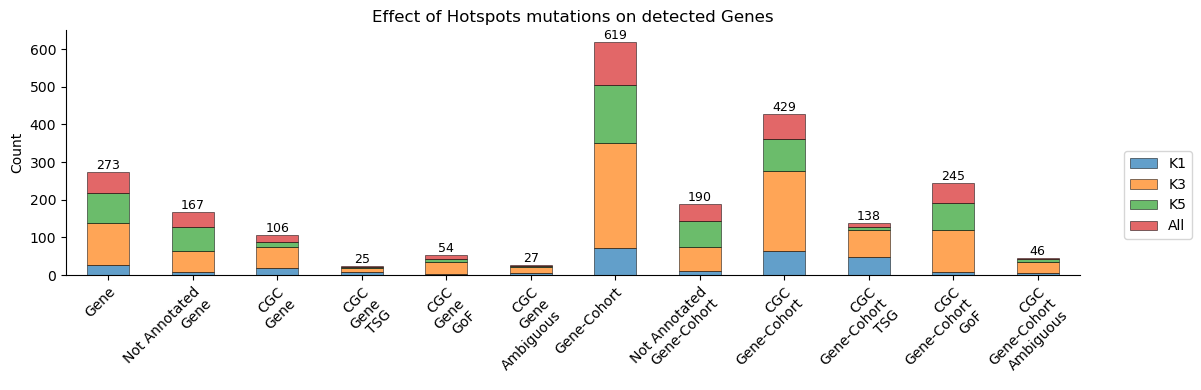

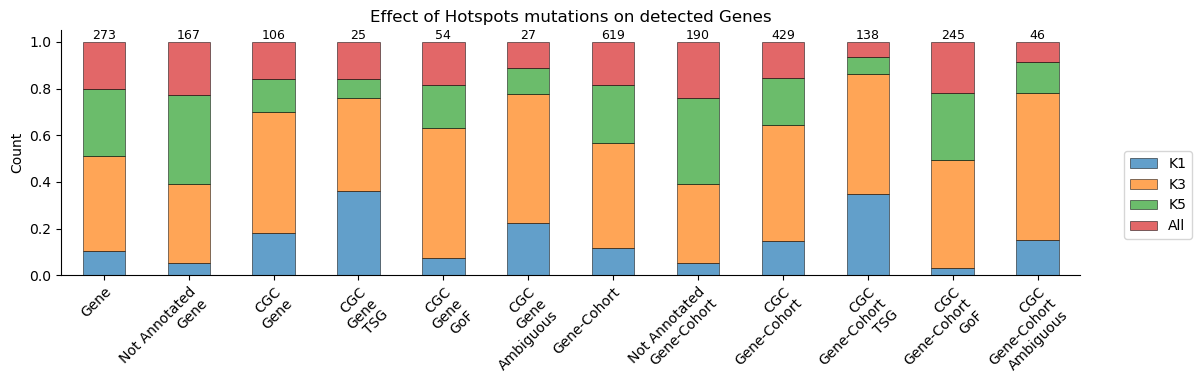

In [25]:
# Counts
# ------

df_stacked_counts = pd.DataFrame({
    'Gene': counts_unique,
    "Not Annotated\nGene": counts_notannot_unique,
    "CGC\nGene": counts_cgc_unique,
    "CGC\nGene\nTSG": counts_tsg_unique,
    "CGC\nGene\nGoF": counts_gof_unique,
    "CGC\nGene\nAmbiguous": counts_ambiguous_unique,

    'Gene-Cohort': counts,
    "Not Annotated\nGene-Cohort": counts_notannot,
    "CGC\nGene-Cohort": counts_cgc,
    "CGC\nGene-Cohort\nTSG": counts_tsg,
    "CGC\nGene-Cohort\nGoF": counts_gof,
    "CGC\nGene-Cohort\nAmbiguous": counts_ambiguous,
})

df_stacked_counts = df_stacked_counts.T

fig, ax = plt.subplots(figsize=(11, 4))
df_stacked_counts.plot(kind="bar", stacked=True, ax=ax, alpha=0.7, legend=False, lw=0.5, ec="black")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, col in enumerate(df_stacked_counts.T.columns):
    total = df_stacked_counts.T[col].sum()
    ax.text(i, total, str(int(total)), ha='center', va='bottom', fontsize=9)

plt.ylabel("Count")
plt.title("Effect of Hotspots mutations on detected Genes")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


# Ratios
# ------

df_stacked = pd.DataFrame({
    'Gene': ratios_unique,
    "Not Annotated\nGene": ratios_notannot_unique,
    "CGC\nGene": ratios_cgc_unique,
    "CGC\nGene\nTSG": ratios_tsg_unique,
    "CGC\nGene\nGoF": ratios_gof_unique,
    "CGC\nGene\nAmbiguous": ratios_ambiguous_unique,

    'Gene-Cohort': ratios,
    "Not Annotated\nGene-Cohort": ratios_notannot,
    "CGC\nGene-Cohort": ratios_cgc,
    "CGC\nGene-Cohort\nTSG": ratios_tsg,
    "CGC\nGene-Cohort\nGoF": ratios_gof,
    "CGC\nGene-Cohort\nAmbiguous": ratios_ambiguous,
})

df_stacked = df_stacked.T

fig, ax = plt.subplots(figsize=(11, 4))
df_stacked.plot(kind="bar", stacked=True, ax=ax, legend=False, alpha=0.7, lw=0.5, ec="black")

for i, col in enumerate(df_stacked_counts.T.columns):
    total = df_stacked_counts.T[col].sum()
    ax.text(i, 1, str(int(total)), ha='center', va='bottom', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Count")
plt.title("Effect of Hotspots mutations on detected Genes")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

/tmp/ipykernel_1160105/3066479414.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


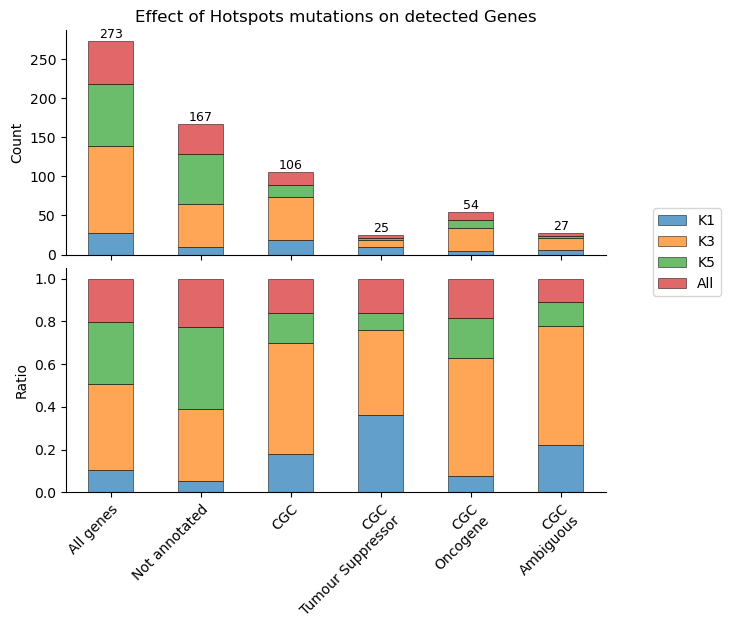

In [59]:
# Counts and ratios Genes
# -----------------------

df_stacked_counts = pd.DataFrame({
    'All genes': counts_unique,
    "Not annotated": counts_notannot_unique,
    "CGC": counts_cgc_unique,
    "CGC\nTumour Suppressor": counts_tsg_unique,
    "CGC\nOncogene": counts_gof_unique,
    "CGC\nAmbiguous": counts_ambiguous_unique
})
df_stacked_counts = df_stacked_counts.T

df_stacked = pd.DataFrame({
    'All genes': ratios_unique,
    "Not annotated": ratios_notannot_unique,
    "CGC": ratios_cgc_unique,
    "CGC\nTumour Suppressor": ratios_tsg_unique,
    "CGC\nOncogene": ratios_gof_unique,
    "CGC\nAmbiguous": ratios_ambiguous_unique
})
df_stacked = df_stacked.T


# Create a figure with two rows, shared x-axis
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    sharex=True,
    figsize=(8, 6),
    gridspec_kw={
        'height_ratios': [1, 1],
        'hspace': 0.06
        }
)

# Top: Counts
df_stacked_counts.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    alpha=0.7,
    legend=False,
    lw=0.5,
    ec="black"
)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylabel("Count")
axes[0].set_title("Effect of Hotspots mutations on detected Genes")

# Annotate total counts above each bar
for i, col in enumerate(df_stacked_counts.T.columns):
    total = df_stacked_counts.T[col].sum()
    axes[0].text(i, total, str(int(total)), ha='center', va='bottom', fontsize=9)

# Bottom: Ratios
df_stacked.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    alpha=0.7,
    legend=False,
    lw=0.5,
    ec="black"
)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_ylabel("Ratio")

# Optionally annotate something at y=1 (if that makes sense):
# for i, col in enumerate(df_stacked.columns):
#     axes[1].text(i, 1.02, "1.00", ha='center', va='bottom', fontsize=9)

# Rotate only the bottom x-ticks
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")

# Shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='center left',
    bbox_to_anchor=(0.85, 0.51)
)

plt.tight_layout()
plt.subplots_adjust(right=0.8)  # make space for the legend
plt.show()


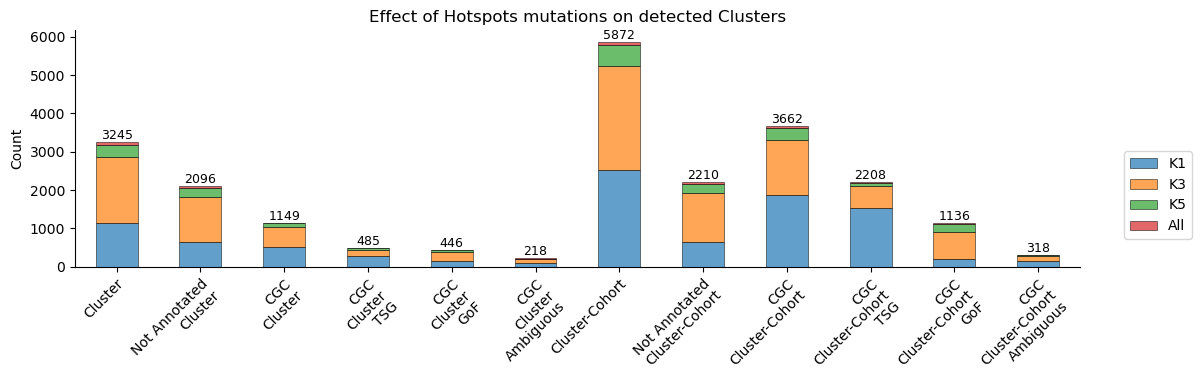

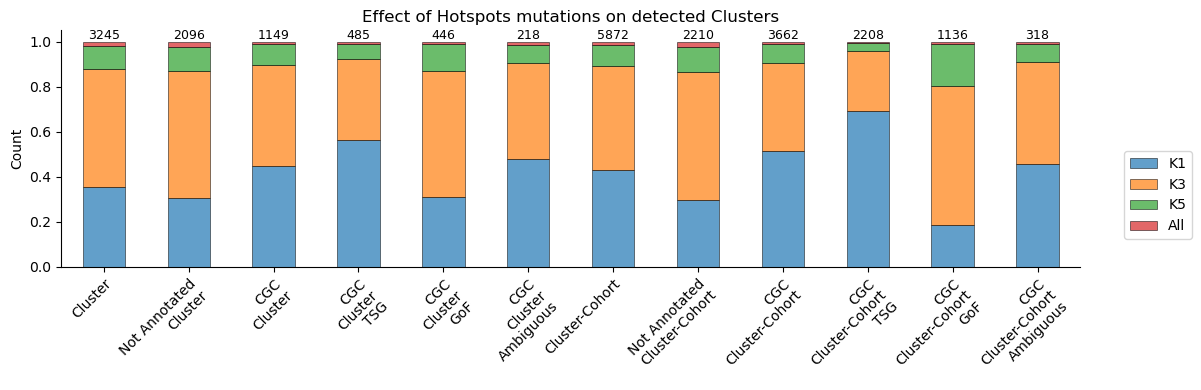

In [ ]:
# Counts
# ------

df_stacked_counts = pd.DataFrame({
    'Cluster': counts_res_unique,
    "Not Annotated\nCluster": counts_res_notannot_unique,
    "CGC\nCluster": counts_res_cgc_unique,
    "CGC\nCluster\nTSG": counts_res_tsg_unique,
    "CGC\nCluster\nGoF": counts_res_gof_unique,
    "CGC\nCluster\nAmbiguous": counts_res_ambiguous_unique,

    'Cluster-Cohort': counts_res,
    "Not Annotated\nCluster-Cohort": counts_res_notannot,
    "CGC\nCluster-Cohort": counts_res_cgc,
    "CGC\nCluster-Cohort\nTSG": counts_res_tsg,
    "CGC\nCluster-Cohort\nGoF": counts_res_gof,
    "CGC\nCluster-Cohort\nAmbiguous": counts_res_ambiguous,
})

df_stacked_counts = df_stacked_counts.T

fig, ax = plt.subplots(figsize=(11, 4))
df_stacked_counts.plot(kind="bar", stacked=True, ax=ax, alpha=0.7, legend=False, lw=0.5, ec="black")

for i, col in enumerate(df_stacked_counts.T.columns):
    total = df_stacked_counts.T[col].sum()
    ax.text(i, total, str(int(total)), ha='center', va='bottom', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Count")
plt.title("Effect of Hotspots mutations on detected Clusters")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


# Ratios
# ------

df_stacked = pd.DataFrame({
    'Cluster': ratios_res_unique,
    "Not Annotated\nCluster": ratios_res_notannot_unique,
    "CGC\nCluster": ratios_res_cgc_unique,
    "CGC\nCluster\nTSG": ratios_res_tsg_unique,
    "CGC\nCluster\nGoF": ratios_res_gof_unique,
    "CGC\nCluster\nAmbiguous": ratios_res_ambiguous_unique,

    'Cluster-Cohort': ratios_res,
    "Not Annotated\nCluster-Cohort": ratios_res_notannot,
    "CGC\nCluster-Cohort": ratios_res_cgc,
    "CGC\nCluster-Cohort\nTSG": ratios_res_tsg,
    "CGC\nCluster-Cohort\nGoF": ratios_res_gof,
    "CGC\nCluster-Cohort\nAmbiguous": ratios_res_ambiguous,
})

df_stacked = df_stacked.T

fig, ax = plt.subplots(figsize=(11, 4))
df_stacked.plot(kind="bar", stacked=True, ax=ax, legend=False, alpha=0.7, lw=0.5, ec="black")

for i, col in enumerate(df_stacked_counts.T.columns):
    total = df_stacked_counts.T[col].sum()
    ax.text(i, 1, str(int(total)), ha='center', va='bottom', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Count")
plt.title("Effect of Hotspots mutations on detected Clusters")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()